In [35]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString, Point, MultiPoint
import networkx as nx
import geonetworkx as gnx
import google_conf
import numpy as np

In [37]:
plt.style.use('seaborn-white')
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    fig.savefig("../figures/" + fig_name + ".tiff")
    fig.savefig("../figures/" + fig_name + ".png")

In [3]:
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson", driver="GeoJSON")
pleiades_regions_merged = pleiades_regions.unary_union

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/pygeos/set_operations.py:388: RuntimeWarning: invalid value encountered in unary_union
  result = lib.unary_union(collections, **kwargs)


In [4]:
provinces = gpd.read_file("../data/roman_province_boundaries.json")
provinces = provinces.to_crs(3035)
len(provinces)

61

In [5]:
provinces = gpd.read_file("../data/provinces_valid.geojson")
provinces = provinces.to_crs(3035)
len(provinces)

61

In [6]:
provinces_unary_union = provinces.unary_union

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/pygeos/set_operations.py:388: RuntimeWarning: invalid value encountered in unary_union
  result = lib.unary_union(collections, **kwargs)


In [9]:
# based on advice from ChatGPT...
invalid_geometries = provinces[~provinces.geometry.is_valid]
# Make invalid geometries valid by buffering with a distance of 0
provinces.loc[~provinces.geometry.is_valid, 'geometry'] = invalid_geometries.buffer(0)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/pygeos/constructive.py:175: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


In [11]:
provinces.to_file("../data/provinces_valid.geojson", driver="GeoJSON")

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [7]:
provinces = provinces.to_crs("EPSG:4326")

In [8]:
origo_geo = gpd.read_parquet("../data/origo_geo.parquet")
origo_geo = origo_geo.set_geometry("edh_point")
origo_geo.crs = "EPSG:4326"

In [9]:
origo_geo = gpd.sjoin(origo_geo, provinces, how="left")
origo_geo.rename(columns={"province" : "province_dest", "index_right" : "dest_index"}, inplace=True)

In [10]:
origo_geo = origo_geo.set_geometry("origo_point")
origo_geo.crs = "EPSG:4326"
origo_geo = gpd.sjoin(origo_geo, provinces, how="left")
origo_geo.rename(columns={"province" : "province_source", "index_right" : "source_index"}, inplace=True)

In [11]:
origo_geo

,id,hd_nr,origo,origo_clean,pleiades_id,pleiades_title_list,pleiades_Latitude,pleiades_Longitude,pleiades_title,Certainty,...,1BCE,1CE,2CE,3CE,4CE,5CE,dest_index,province_dest,source_index,province_source
0,HD075902/1,HD075902,cives(!) (= civis) Nervius+,() (= ) Nervius,109199.0,None,50.777494,4.084768,Nervii,certain,...,False,False,True,True,False,False,28.0,Germania Inferior,24.0,Belgica
1,HD081444/1,HD081444,natione(?)Pannonius,()Pannonius,992076.0,None,47.500000,12.500000,Pannoniae,uncertain (name could be interpreted differently),...,False,False,True,True,False,False,20.0,Britannia,42.0,Noricum
2,HD056833/3,HD056833,cives(= civis) Convena*,(= ) Convena,246357.0,None,42.966682,0.269919,Convenae,certain,...,False,False,True,False,False,False,41.0,Hispania Citerior,26.0,Aquitania
3,HD018231/1,HD018231,cives(= civis) Veliocassinius,(= ) Veliocassinius,109412.0,None,49.364001,0.831097,Veliocasses,certain,...,False,False,True,True,False,False,28.0,Germania Inferior,27.0,Lugdunensis
4,HD010286/1,HD010286,natione+* [---] Aelia [---],[---] Aelia [---],197389.0,None,45.560018,18.675749,Mursa,uncertain (name could be interpreted differently),...,False,False,True,False,False,False,6.0,Latium et Campania (Regio I),43.0,Pannonia Inferior
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566,HD037345/1,HD037345,natione Zoela!,Zoela,236724.0,None,41.717349,-6.628006,Zoelae,certain,...,False,True,False,False,False,False,43.0,Pannonia Inferior,41.0,Hispania Citerior
2589,HD056506/2,HD056506,Ἐφέσιος,Ἐφέσιος,599612.0,None,37.940762,27.340307,Ephesus/Arsinoe(ia),certain,...,True,False,False,False,False,False,0.0,Achaia,19.0,Asia
2607,HD025474/5,HD025474,Μιλήσιος,Μιλήσιος,599799.0,None,37.522905,27.278317,Miletus,certain,...,False,False,True,False,False,False,46.0,Aegyptus,19.0,Asia
2637,HD008584/6,HD008584,natione verna,None,167964.0,None,45.776152,5.281057,Vernas,wild guess,...,True,False,False,False,False,False,6.0,Latium et Campania (Regio I),25.0,Narbonensis


In [12]:
centroid_series = provinces.centroid

/var/folders/zg/zvg9y3rs7j527jxfq9sc2xqc0000gn/T/ipykernel_45285/1802002792.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_series = provinces.centroid


In [13]:
pronvinces_edges_weighted = origo_geo.groupby(["source_index", "dest_index"], as_index=False).size()
pronvinces_edges_weighted.rename(columns={"size" : "weight"}, inplace=True)
pronvinces_edges_weighted

,source_index,dest_index,weight
0,0.0,0.0,1
1,0.0,6.0,2
2,0.0,20.0,4
3,0.0,23.0,1
4,0.0,24.0,1
...,...,...,...
586,60.0,56.0,3
587,60.0,57.0,1
588,60.0,58.0,3
589,60.0,59.0,1


In [14]:
origo_geo[(origo_geo["source_index"]==0) & (origo_geo["dest_index"]==20)]

,id,hd_nr,origo,origo_clean,pleiades_id,pleiades_title_list,pleiades_Latitude,pleiades_Longitude,pleiades_title,Certainty,...,1BCE,1CE,2CE,3CE,4CE,5CE,dest_index,province_dest,source_index,province_source
343,HD001389/1,HD001389,natus* Athenis*,Athenis,579885.0,None,37.972454,23.726268,Athenae,uncertain (another good variant exists),...,False,True,False,False,False,False,20.0,Britannia,0.0,Achaia
1078,HD069555/1,HD069555,natione Grecus,Grecus,1001896.0,None,37.500000,22.500000,Hellas,uncertain (name could be interpreted differently),...,False,False,True,True,False,False,20.0,Britannia,0.0,Achaia
1079,HD070191/1,HD070191,civis Grecus,Grecus,1001896.0,None,37.500000,22.500000,Hellas,uncertain (name could be interpreted differently),...,False,False,False,False,True,False,20.0,Britannia,0.0,Achaia
1415,HD069852/1,HD069852,domo Melitenis,Melitenis,582863.0,None,37.979531,23.718407,Melite,uncertain (another good variant exists),...,False,False,False,True,False,False,20.0,Britannia,0.0,Achaia


In [15]:
origo_geo.to_parquet("../data/origo_geo_provinces.parquet")

/var/folders/zg/zvg9y3rs7j527jxfq9sc2xqc0000gn/T/ipykernel_45285/2069510573.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  origo_geo.to_parquet("../data/origo_geo_provinces.parquet")


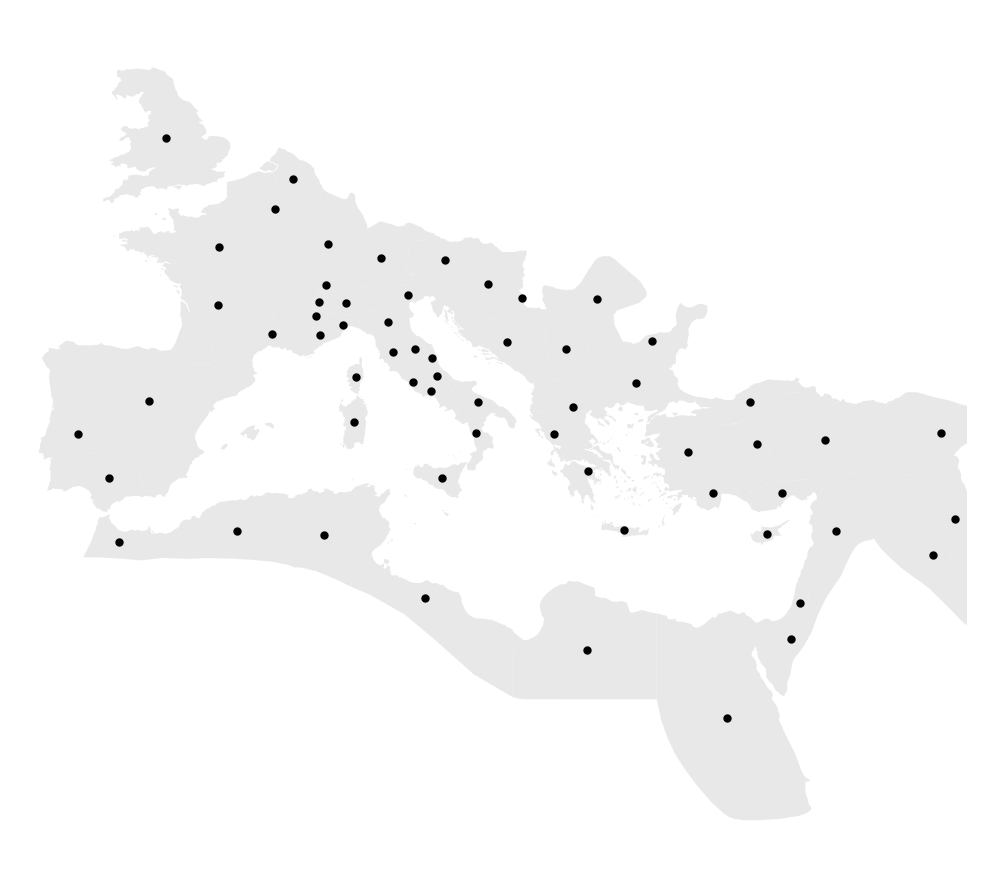

In [16]:
fig, ax = plt.subplots(figsize=(5.2, 3), dpi=300, tight_layout=True)
provinces.plot(color="lightgray", ax=ax, alpha=0.5)
centroid_series.plot(markersize=1, color="black", ax=ax)
ax.set_xlim(-10, 45)
ax.set_axis_off()

In [17]:
G = gnx.GeoDiGraph()

In [18]:
G.add_nodes_from_gdf(provinces)

In [19]:
G.nodes(data=True)

NodeDataView({0: {'geometry': <shapely.geometry.multipolygon.MultiPolygon object at 0x2882c83a0>, 'province': 'Achaia'}, 1: {'geometry': <shapely.geometry.polygon.Polygon object at 0x107900c40>, 'province': 'Alpes Poeninae'}, 2: {'geometry': <shapely.geometry.polygon.Polygon object at 0x2882f7730>, 'province': 'Alpes Graiae'}, 3: {'geometry': <shapely.geometry.polygon.Polygon object at 0x2882f7280>, 'province': 'Umbria (Regio VI)'}, 4: {'geometry': <shapely.geometry.polygon.Polygon object at 0x28835be80>, 'province': 'Picenum (Regio V)'}, 5: {'geometry': <shapely.geometry.polygon.Polygon object at 0x2881f1a00>, 'province': 'Samnium (Regio IV)'}, 6: {'geometry': <shapely.geometry.polygon.Polygon object at 0x2882c8430>, 'province': 'Latium et Campania (Regio I)'}, 7: {'geometry': <shapely.geometry.polygon.Polygon object at 0x2882c8490>, 'province': 'Etruria (Regio VII)'}, 8: {'geometry': <shapely.geometry.polygon.Polygon object at 0x2882c8670>, 'province': 'Transpadana (Regio XI)'}, 9: {

In [20]:
pronvinces_edges_weighted

,source_index,dest_index,weight
0,0.0,0.0,1
1,0.0,6.0,2
2,0.0,20.0,4
3,0.0,23.0,1
4,0.0,24.0,1
...,...,...,...
586,60.0,56.0,3
587,60.0,57.0,1
588,60.0,58.0,3
589,60.0,59.0,1


In [21]:
pronvinces_edges_weighted.to_csv("../data/pronvinces_edges_weighted.csv")

In [22]:
pronvinces_edges_weighted_tuples = [tuple(el) for el in pronvinces_edges_weighted.values.tolist()]
pronvinces_edges_weighted_tuples[:10]

[(0.0, 0.0, 1.0),
 (0.0, 6.0, 2.0),
 (0.0, 20.0, 4.0),
 (0.0, 23.0, 1.0),
 (0.0, 24.0, 1.0),
 (0.0, 28.0, 1.0),
 (0.0, 29.0, 1.0),
 (0.0, 30.0, 4.0),
 (0.0, 39.0, 1.0),
 (0.0, 41.0, 2.0)]

In [23]:
G.add_weighted_edges_from(pronvinces_edges_weighted_tuples)
G.remove_edges_from(nx.selfloop_edges(G))

In [24]:
G.edges(data=True)

OutEdgeDataView([(0, 6.0, {'weight': 2.0}), (0, 20.0, {'weight': 4.0}), (0, 23.0, {'weight': 1.0}), (0, 24.0, {'weight': 1.0}), (0, 28.0, {'weight': 1.0}), (0, 29.0, {'weight': 1.0}), (0, 30.0, {'weight': 4.0}), (0, 39.0, {'weight': 1.0}), (0, 41.0, {'weight': 2.0}), (0, 43.0, {'weight': 1.0}), (0, 56.0, {'weight': 1.0}), (0, 58.0, {'weight': 1.0}), (0, 59.0, {'weight': 1.0}), (0, 60.0, {'weight': 2.0}), (1, 23.0, {'weight': 1.0}), (1, 58.0, {'weight': 1.0}), (1, 59.0, {'weight': 1.0}), (3, 6.0, {'weight': 3.0}), (3, 7.0, {'weight': 1.0}), (3, 23.0, {'weight': 4.0}), (3, 28.0, {'weight': 3.0}), (3, 44.0, {'weight': 2.0}), (3, 56.0, {'weight': 1.0}), (3, 58.0, {'weight': 2.0}), (3, 59.0, {'weight': 2.0}), (3, 60.0, {'weight': 3.0}), (4, 3.0, {'weight': 1.0}), (4, 6.0, {'weight': 2.0}), (4, 20.0, {'weight': 2.0}), (4, 23.0, {'weight': 2.0}), (4, 28.0, {'weight': 3.0}), (4, 42.0, {'weight': 1.0}), (4, 44.0, {'weight': 2.0}), (4, 56.0, {'weight': 1.0}), (4, 58.0, {'weight': 2.0}), (4, 60.0

In [25]:
indegrees = nx.in_degree_centrality(G)

In [26]:
centroid_series_pos = centroid_series.apply(lambda point: (point.x, point.y))

In [27]:
pos_dict = dict(zip(range(len(centroid_series_pos)), centroid_series_pos.tolist()))
pos_dict

{0: (22.745937458015508, 37.88293450237131),
 1: (7.3502528019699716, 46.28082275400978),
 2: (6.936089574726397, 45.52158927224306),
 3: (12.57540342640504, 43.36422703077655),
 4: (13.595846804035473, 42.99114524151195),
 5: (13.890619981523304, 42.158474991497535),
 6: (13.559398412079501, 41.50852910364442),
 7: (11.302168656153208, 43.23143533390114),
 8: (8.54253006433644, 45.467563045901976),
 9: (8.353421202663847, 44.4763739571707),
 10: (11.000893039018138, 44.603378611779306),
 11: (6.80535575677571, 44.872877972798186),
 12: (7.031725786172907, 44.00683043899889),
 13: (12.160602407499251, 45.83353827161291),
 14: (16.151877146419874, 39.6157851918229),
 15: (14.177160478040552, 37.57898844554503),
 16: (9.031052009998177, 40.08214466546073),
 17: (9.103900564175762, 42.14057971967698),
 18: (16.301758360471204, 41.00382599894712),
 19: (28.58449301261493, 38.76384473724245),
 20: (-2.0212971216897078, 52.903105515524274),
 21: (24.857080449996616, 35.229967338064704),
 22:

TypeError: '_AxesStack' object is not callable

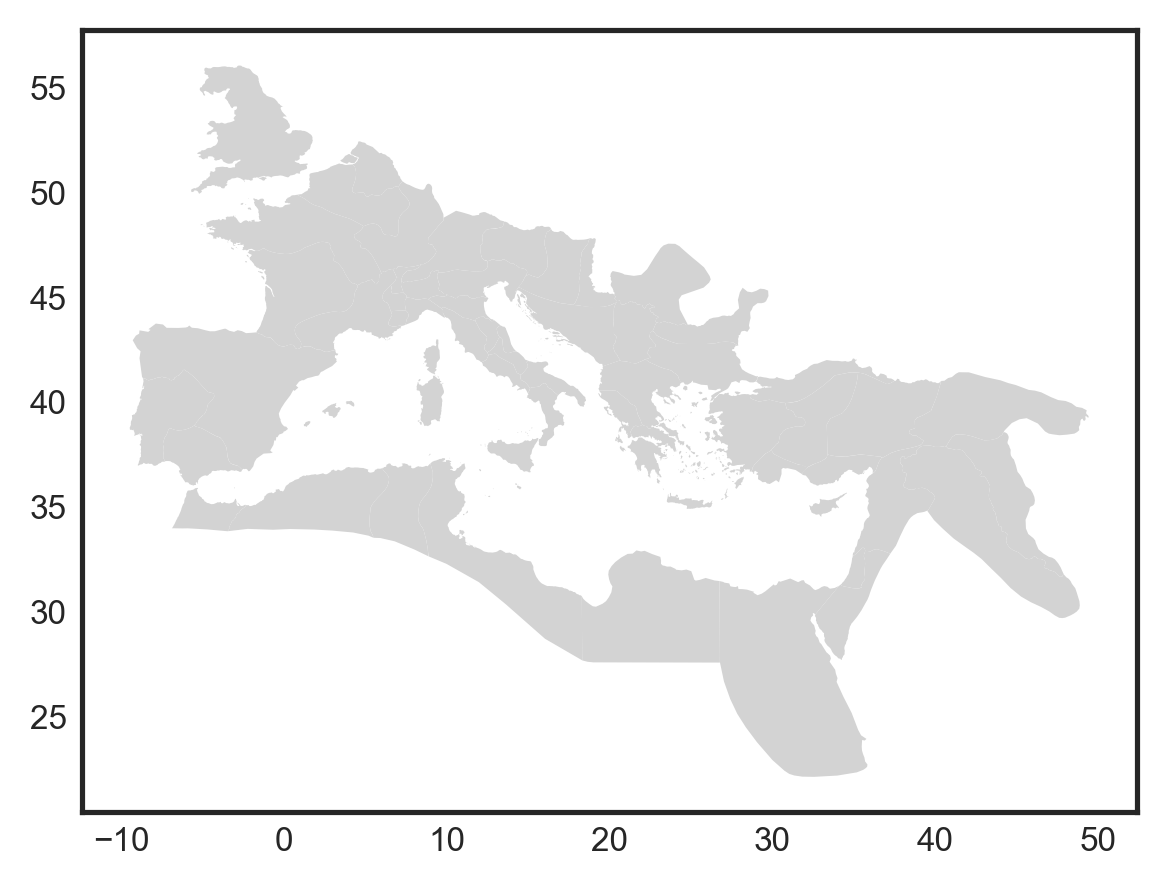

In [30]:
fig, ax = plt.subplots(figsize=(5.2, 3), dpi=300, tight_layout=True)
provinces.plot(color="lightgray", ax=ax)
nx.draw(G, pos=pos_dict)

In [31]:
indegrees = nx.in_degree_centrality(G)
node_sizes = list(indegrees.values())

In [32]:
def plot_network(G, edge_width_attr="weight", margins = 0.2, pos=pos_dict, legend_dict=None,ax=None):
    node_colors = ["black" for node in G.nodes()]
    indegrees = nx.in_degree_centrality(G)
    node_sizes = [val *50 for val in  list(indegrees.values())]
    edge_sizes = [np.log2(w*1) for w in nx.get_edge_attributes(G, edge_width_attr).values()]
    if ax == None:
        fig, ax = plt.subplots()
    ax.set_axis_off()
    layer_edges = nx.draw_networkx_edges(G,
                                         pos=pos,
                                         alpha=0.4,
                                         width= edge_sizes,
                                         style="solid",
                                         edge_color="darkblue",
                                         connectionstyle="arc3,rad=0.2",
                                         ax=ax)
    layer_nodes = nx.draw_networkx_nodes(G,
                                         pos=pos,
                                         node_size=node_sizes,
                                         node_color=node_colors,
                                         ax=ax)
    #layer_labels = nx.draw_networkx_labels(H,
    #                                       pos=pos,
    #                                       font_size=8,
    #                                       ax=ax)
    #if legend_dict != None:
    #    markers = [plt.Line2D([0,0],[0,0], marker="o", color=color, lw=0) for color in legend_dict.values()]
    #    ax.legend(markers, legend_dict.keys(), bbox_to_anchor=(0, 0), loc='upper left', frameon=False)
    layers = [layer_edges, layer_nodes] #, layer_labels]
    return

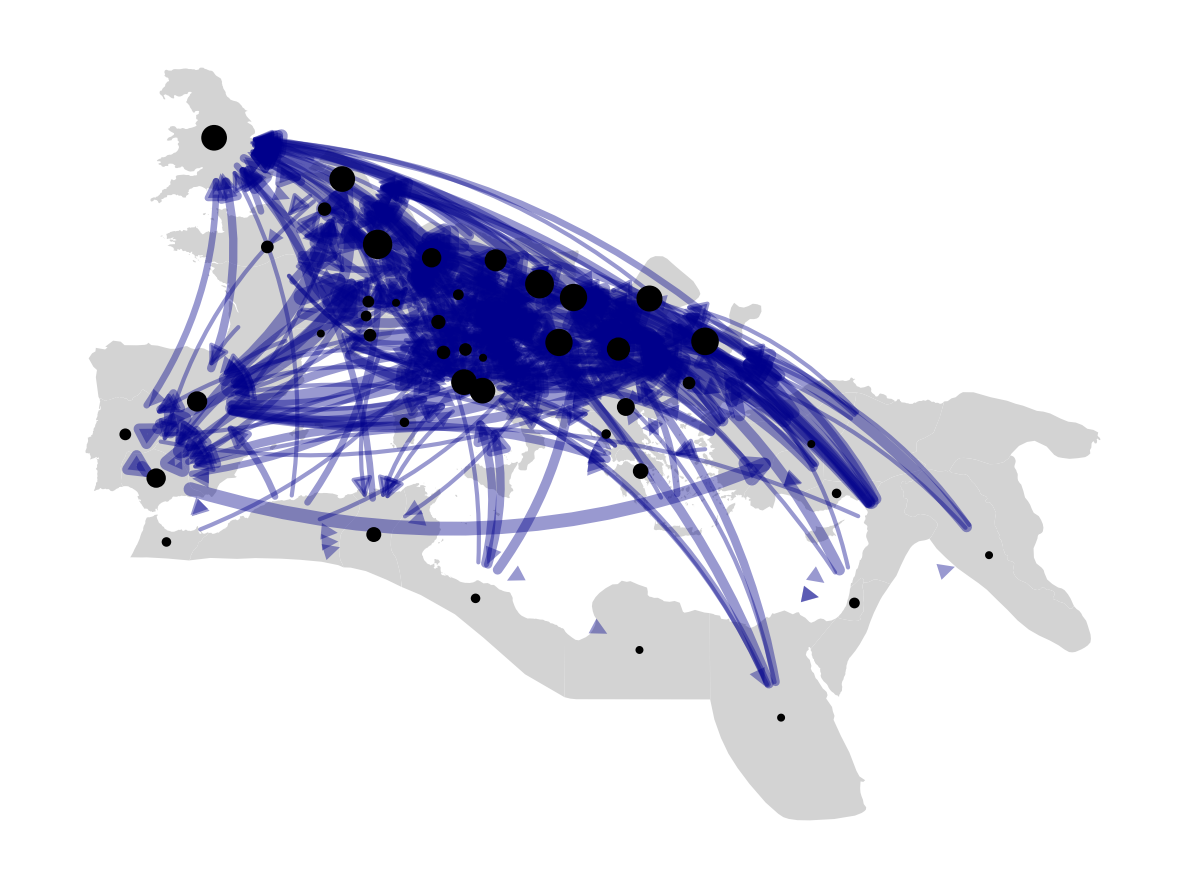

In [33]:
fig, ax = plt.subplots(figsize=(5.2, 3), dpi=300, tight_layout=True)
provinces.plot(color="lightgray", ax=ax)
plot_network(G, edge_width_attr="weight", margins = 0.2, pos=pos_dict, ax=ax)